# Exercise 3

In [46]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import tensorboard
from sklearn.decomposition import PCA

import os
import matplotlib.pyplot as plt
import time
import copy
import numpy as np
import seaborn as sns
import pandas as pd

# Defining CNN

In [101]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,kernel_size = 5,stride = 1,padding=2)
        self.avgPool = nn.AvgPool2d(kernel_size = 2,stride=2)
        self.conv2 = nn.Conv2d(6,16,kernel_size = 5,stride=1)
        self.conv3 = nn.Conv2d(16,120,kernel_size = 5,stride=1)

        self.fc1 = nn.Linear(120,84)
        self.fc2 = nn.Linear(84,10)
        

    def forward(self, x):
        
        x = self.feature_extract(x)
    
        x = F.tanh(self.fc1(x))
        x = self.fc2(x)
        
        return F.log_softmax(x)
    
    def feature_extract(self, x):
        x = F.tanh(self.conv1(x))
        x = self.avgPool(x)
        
        x = F.tanh(self.conv2(x))
        x = self.avgPool(x)
        
        x = F.tanh(self.conv3(x))
        
        x = x.view(-1,120)
        
        return x

cnn = CNN()


# Setting Hyperparameters

In [19]:
learning_rate = 1e-6
batch_size_train = 64
batch_size_test = 1000

momentum = 0.5
epochs = 10
log_interval = 100

In [20]:
optimizer = optim.SGD(cnn.parameters(), lr=learning_rate,
                      momentum=momentum)

# Downloading MNIST

In [14]:
#MNIST
batch_size_train = 64
batch_size_test = 1000

train_mnist = torchvision.datasets.MNIST('mnist/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))]))


test_mnist = torchvision.datasets.MNIST('mnist/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))]))

train_loader = torch.utils.data.DataLoader(train_mnist,batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_mnist,batch_size=batch_size_test, shuffle=True)


In [30]:
def train(epochs,network,train_loader,optimizer, filename="model.pth"):
    train_losses = []
    train_counter = []
    writer = SummaryWriter()
    
    network.train()
    for epoch in range(epochs):
        
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = network(data)

            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()

            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
                train_losses.append(loss.item())
                train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

    torch.save(network.state_dict(), str('results/'+ filename))
    torch.save(optimizer.state_dict(), str('results/'+ "optimizer_" + filename))


In [16]:
def test(network,test_loader):
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(epochs + 1)]
    
    network.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.cross_entropy(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            test_loss /= len(test_loader.dataset)
            test_losses.append(test_loss)
            
    print('\rTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)), end="\r")

# Training CNN

In [102]:
train(1, cnn, train_loader, optimizer)

C:\Users\andre\anaconda3\envs\nnlm\lib\site-packages\torch\nn\functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
C:\Users\andre\anaconda3\envs\nnlm\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.290231
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.317705
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.296803
Train Epoch: 0 [19200/60000 (32%)]	Loss: 2.308353
Train Epoch: 0 [25600/60000 (43%)]	Loss: 2.297668
Train Epoch: 0 [32000/60000 (53%)]	Loss: 2.302843
Train Epoch: 0 [38400/60000 (64%)]	Loss: 2.308275
Train Epoch: 0 [44800/60000 (75%)]	Loss: 2.304984
Train Epoch: 0 [51200/60000 (85%)]	Loss: 2.292749
Train Epoch: 0 [57600/60000 (96%)]	Loss: 2.306561


In [111]:
total_images = []
total_labels = []
for data, labels in train_loader:
    total_images.append(cnn.feature_extract(data))
    total_labels.append(labels)
    for image in data:
        total_images.append(cnn.feature_extract(image))
    for label in labels:
        total_labels.append(label)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [6, 1, 5, 5], but got 3-dimensional input of size [1, 28, 28] instead

In [109]:
print(len(total_images))

938


In [97]:
print(total_images[0].shape)
# total_images = np.array(total_images)
total_images = torch.from_numpy(total_images)

torch.Size([1, 28, 28])


TypeError: expected np.ndarray (got list)

In [107]:
# features = cnn.feature_extract(torch.Tensor(total_images))
features
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(features.detach().numpy())

principalDf =pd.DataFrame(data = principalComponents, columns = ['principalcomponent1',  'principalcomponent2'])

labelPd =pd.DataFrame(labels)



principalDf = pd.concat([principalDf, labelPd], axis = 1, join="inner", ignore_index=True)
principalDf.columns = ["principalcomponent1", "principalcomponent2", "label"]
principalDf.head()

ValueError: only one element tensors can be converted to Python scalars

<Figure size 936x720 with 0 Axes>

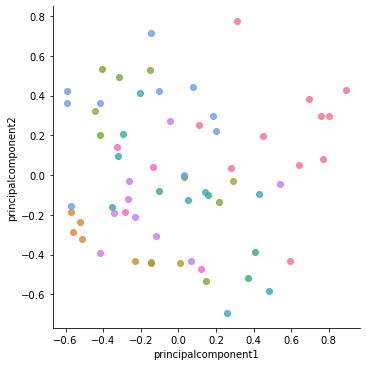

<Figure size 936x720 with 0 Axes>

In [70]:
flatui = ["#9b59b6", "#3498db", "orange"]
sns.set_palette(flatui)
sns.lmplot( x="principalcomponent1", y="principalcomponent2", data=principalDf, fit_reg=False,
           hue='label', legend=False)

plt.figure(figsize=(13,10))